### Pull Data
- Typically, the portfolio and returns will be computed at a pre-chosen frequency.
- In this case, we use a daily frequency.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np 

# get S&P500 tickers
tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0].Symbol.to_list()
tickers = [x.replace('.','-') for x in tickers]

# Get the data for this tickers from yahoo finance
data = yf.download(tickers,'2021-1-1','2021-12-12')

# compute returns
ret = data['Adj Close'] / data['Adj Close'].shift() - 1
ret = ret.iloc[1:]

# stats function for later
def get_stats(strat_ret):
    stats = {}
    stats['SR'] = strat_ret.mean() / strat_ret.std() * np.sqrt(252)
    stats['ret'] = strat_ret.mean()*252
    stats['vol'] = strat_ret.std()*np.sqrt(252)
    stats = pd.Series(stats)
    return stats

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
- CEG: Data doesn't exist for startDate = 1609477200, endDate = 1639285200
- GEHC: Data doesn't exist for startDate = 1609477200, endDate = 1639285200


In [2]:
ret.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-05 00:00:00-05:00,0.008176,0.019828,-0.001081,0.012364,0.010340,0.013057,0.012373,0.004011,0.005693,0.000721,...,0.030776,-0.009747,0.048193,0.028651,-0.001204,0.000094,0.017302,0.006453,0.015840,0.006969
2021-01-06 00:00:00-05:00,0.027423,0.005833,0.057772,-0.033661,-0.008638,0.086027,-0.002082,0.043950,0.010933,-0.039902,...,0.005990,0.022147,0.025517,0.048291,0.042181,0.005481,0.028496,0.037444,0.112360,0.014691
2021-01-07 00:00:00-05:00,0.026609,-0.009021,0.008541,0.034123,0.010703,0.037299,0.009707,-0.009295,0.009435,0.024512,...,-0.009923,-0.019561,0.007846,-0.005176,0.045389,-0.007612,-0.005928,0.036168,0.030509,-0.000898
2021-01-08 00:00:00-05:00,0.007134,-0.016255,0.014254,0.008631,0.005248,-0.000908,0.002785,0.005519,0.003648,0.015406,...,-0.006560,0.009208,0.011121,0.009018,-0.010140,0.014678,-0.002197,-0.008873,-0.025405,0.006647
2021-01-11 00:00:00-05:00,0.008579,-0.008592,0.005645,-0.023249,0.016314,-0.024357,-0.006899,-0.007409,-0.014423,-0.022387,...,-0.009172,-0.020681,0.030356,0.005500,-0.012665,0.004853,0.000314,0.020519,0.023604,0.007614


### Create a simple XS 1 day reversal strategy using the rank method

In [3]:
negate = ret*-1.
ranked = negate.rank(1)
demeaned = ranked.subtract(ranked.mean(1),0)
port = demeaned.divide(demeaned.abs().sum(1),0)

<AxesSubplot:>

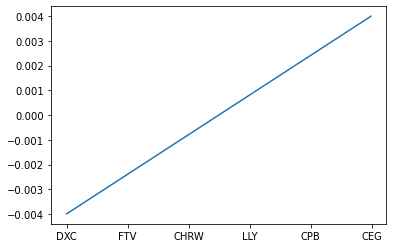

In [4]:
# example portfolio
port.loc['20210330'].sort_values().plot()

<AxesSubplot:xlabel='Date'>

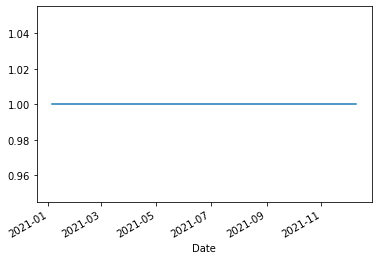

In [5]:
# Fully invested: abs value of port weights should sum to 1
port.abs().sum(1).plot()

<AxesSubplot:xlabel='Date'>

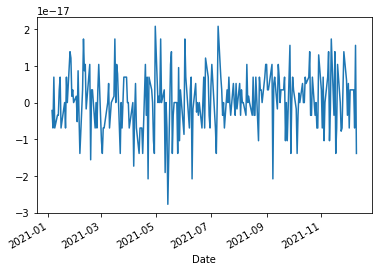

In [6]:
# Dollar neutrality: Port weights should sum to 0
port.sum(1).plot()

In [7]:
# compute strategy returns: implicitly assuming "market orders"
strat_ret = (port.shift()*ret).sum(1)

In [8]:
get_stats(strat_ret)

SR     1.510147
ret    0.102523
vol    0.067890
dtype: float64

<AxesSubplot:xlabel='Date'>

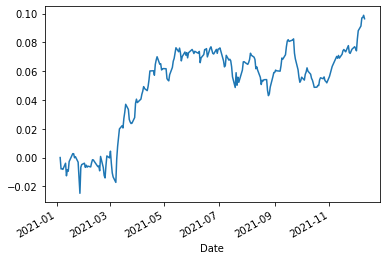

In [9]:
strat_ret.cumsum().plot()

### Create a simple XS 1 day reversal strategy using decile portfolios

In [10]:
negate = ret*-.1
pct = negate.rank(axis=1,pct=True)

long = (pct > 0.9)*1
long = long.divide(long.abs().sum(1),0)*0.5

short = (pct < 0.1)*-1.0
short = short.divide(short.abs().sum(1),0)*0.5

port = short.add(long,fill_value = 0)

<AxesSubplot:>

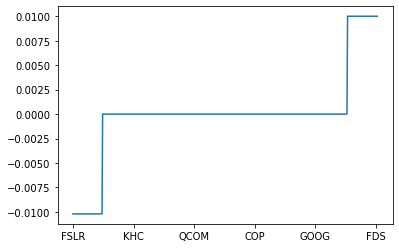

In [11]:
# example portfolio
port.loc['20210330'].sort_values().plot()

<AxesSubplot:xlabel='Date'>

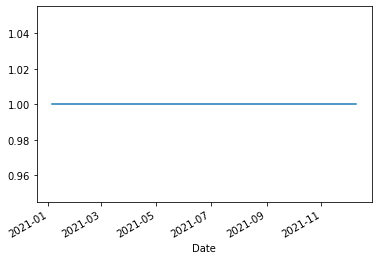

In [12]:
# Fully invested: abs value of port weights should sum to 1
(port.abs()).sum(1).plot()

<AxesSubplot:xlabel='Date'>

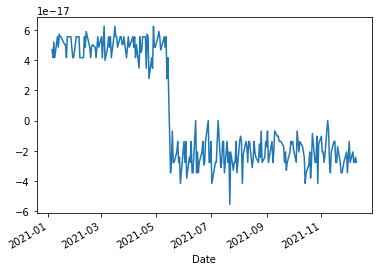

In [13]:
# Dollar neutrality: Port weights should sum to 0
port.sum(1).plot()

In [14]:
# compute strategy returns: implicitly assuming "market orders"
strat_ret = (port.shift()*ret).sum(1)

In [15]:
get_stats(strat_ret)

SR     1.116020
ret    0.122927
vol    0.110148
dtype: float64

<AxesSubplot:xlabel='Date'>

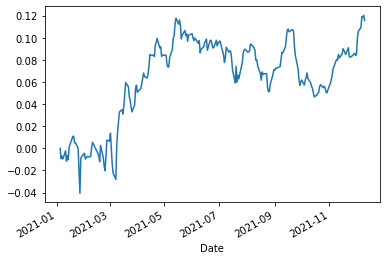

In [16]:
strat_ret.cumsum().plot()